In [1]:
# Import libraries & dataset dirs

import os, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
sns.set_theme(style='ticks', font_scale=1.0)

DATA_DIR = os.path.join('.', 'dataset')

### Meaning of every raw feature in the dataset

| Column        | Hardware source                              | Physical quantity captured                                                          | Reason why its used                                                    |
| ------------- | -------------------------------------------- | ----------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------- |
| **Temp-int**  | BME280 inside the fruit chamber              | °C of air immediately around the bananas                                            | Exothermic respiration rises a few °C as ripening accelerates.                     |
| **Press-int** | Same BME280                                  | Air pressure inside chamber (hPa)                                                   | Mostly constant; slight dips if temp spikes (ideal-gas effect).                    |
| **Humid-int** | Same BME280                                  | %RH next to fruit                                                                   | Transpiration and ethanol vapour raise RH as fruit softens.                        |
| **Temp-ext**  | BME280 mounted outside box                   | Ambient °C                                                                          | Provides baseline to compute ΔT (respiration heat).                                |
| **Press-ext** | External BME280                              | Ambient hPa                                                                         | Lets you isolate true internal pressure changes.                                   |
| **Humid-ext** | External BME280                              | Ambient %RH                                                                         | Used with internal RH to see moisture build-up.                                    |
| **TGS20**     | **Figaro TGS2620** MOS sensor                | Adsorbed-gas resistance, highly sensitive to **ethanol & acetone** (aroma alcohols) | Alcohols spike from stage 3 onward → resistance falls, reading (ADC counts) rises. |
| **TGS02**     | **TGS2602** MOS array                        | Broad **sulphur & amine VOCs**, some NH₃                                            | Protein breakdown vapours appear in stages 4-5.                                    |
| **SGP**       | **Sensirion SGP40** TVOC sensor              | Total VOC index (0-600) / equivalent CO₂ ppm                                        | Steady climb across stages; low-noise digital output.                              |
| **SpA410**    | Hamamatsu C12880MA spectrometer – 410 nm bin | Deep-blue reflectance (anthocyanin absorption)                                      | Increases slightly as chlorophyll clears.                                          |
| **SpB435**    | 435 nm                                       | Sky-blue band                                                                       | Similar rationale.                                                                 |
| **SpC460**    | 460 nm                                       | Blue-green                                                                          | Tracks carotenoid precursor exposure.                                              |
| **SpD485**    | 485 nm                                       | Cyan band                                                                           | –⁠〃–                                                                               |
| **SpE510**    | 510 nm                                       | **Green band** (chlorophyll-a edge)                                                 | Drops sharply from stage 1→3 as peel de-greens.                                    |
| **SpF535**    | 535 nm                                       | **Peak chlorophyll** absorbance                                                     | Signature feature: monotonic fall; nearly linear vs. stage.                        |
| **SpG560**    | 560 nm                                       | Yellow-green                                                                        | Rises as carotenoids dominate.                                                     |
| **SpH585**    | 585 nm                                       | Yellow                                                                              | Continues rising into stage 4 (browning onset).                                    |
| **SpR610**    | 610 nm                                       | Red-orange                                                                          | Constant in this dataset (sensor dark noise → dropped).                            |
| **SpI645**    | 645 nm                                       | Red                                                                                 | Slight decrease; hemicellulose browning affects later.                             |
| **SpS680**    | 680 nm                                       | Deep-red (chlorophyll fluorescence)                                                 | Collapses once chlorophyll gone.                                                   |
| **SpJ705**    | 705 nm                                       | Far-red shoulder                                                                    | –⁠〃–                                                                               |
| **SpT730**    | 730 nm                                       | Far-red/NIR transition                                                              | Reflects water & structural changes.                                               |
| **SpU760**    | 760 nm                                       | Oxygen-A absorption notch (baseline reference)                                      | Mostly stable; used for internal calibration.                                      |
| **SpV810**    | 810 nm                                       | NIR – water overtone                                                                | Rises as peel dehydrates late-stage.                                               |
| **SpW860**    | 860 nm                                       | NIR – cellulose scatter                                                             | Slight trend with softening.                                                       |
| **SpK900**    | 900 nm                                       | NIR water band                                                                      | Complements 810 nm; good humidity proxy inside peel.                               |
| **SpL940**    | 940 nm                                       | Deep NIR – water & sugar                                                            | Tracks sugar concentration rise till over-ripe.                                    |

---


In [2]:
# Read datasets

X_train = pd.read_csv(os.path.join(DATA_DIR, 'ds_34_x_train.csv'), index_col=0)
y_train = pd.read_csv(os.path.join(DATA_DIR, 'ds_34_y_train.csv'), index_col=0, header=0)

X_test  = pd.read_csv(os.path.join(DATA_DIR, 'ds_34_x_test.csv'), index_col=0)
y_test  = pd.read_csv(os.path.join(DATA_DIR, 'ds_34_y_test.csv'), index_col=0, header=0)

y_train.columns = ['label']
y_test.columns = ['label']

print('Raw shapes   →', X_train.shape, X_test.shape)
print('Label counts →', y_train['label'].value_counts().sort_index().to_dict())

Raw shapes   → (18819, 27) (8066, 27)
Label counts → {1: 3764, 2: 3764, 3: 3764, 4: 3764, 5: 3763}


In [3]:
# Drop spectrometer bands and pressure.
print('Initial columns:', X_train.columns.tolist())

X_train.drop(columns=[
    'Press-int', 'Press-ext',
    'SpA410','SpB435','SpC460','SpD485','SpE510','SpF535','SpG560',
    'SpH585','SpR610','SpI645','SpS680','SpJ705','SpT730','SpU760',
    'SpV810','SpW860','SpK900','SpL940'
], inplace=True)

X_test.drop(columns=[
    'Press-int', 'Press-ext',
    'SpA410','SpB435','SpC460','SpD485','SpE510','SpF535','SpG560',
    'SpH585','SpR610','SpI645','SpS680','SpJ705','SpT730','SpU760',
    'SpV810','SpW860','SpK900','SpL940'
], inplace=True)

print('\nRemaining columns:', X_train.columns.tolist())

Initial columns: ['Temp-int', 'Press-int', 'Humid-int', 'Temp-ext', 'Press-ext', 'Humid-ext', 'TGS20', 'TGS02', 'SGP', 'SpA410', 'SpB435', 'SpC460', 'SpD485', 'SpE510', 'SpF535', 'SpG560', 'SpH585', 'SpR610', 'SpI645', 'SpS680', 'SpJ705', 'SpT730', 'SpU760', 'SpV810', 'SpW860', 'SpK900', 'SpL940']

Remaining columns: ['Temp-int', 'Humid-int', 'Temp-ext', 'Humid-ext', 'TGS20', 'TGS02', 'SGP']


<class 'pandas.core.frame.DataFrame'>
Index: 18819 entries, 20799 to 4808
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Temp-int   18819 non-null  float64
 1   Humid-int  18819 non-null  float64
 2   Temp-ext   18819 non-null  float64
 3   Humid-ext  18819 non-null  float64
 4   TGS20      18819 non-null  float64
 5   TGS02      18819 non-null  float64
 6   SGP        18819 non-null  float64
dtypes: float64(7)
memory usage: 1.1 MB


None

,count,mean,std,min,25%,50%,75%,max
Temp-int,18819.0,15.828344,2.819551,9.440000,13.645111,15.565074,17.980000,23.949404
Humid-int,18819.0,63.258961,8.047052,48.750000,55.638745,62.130000,71.521013,81.610000
Temp-ext,18819.0,15.481426,3.047256,8.840000,13.150000,15.200000,17.567555,26.640000
Humid-ext,18819.0,56.732930,11.689875,23.957053,48.968232,58.301609,64.729716,91.029031
TGS20,18819.0,1056.236653,667.984398,116.000000,517.000000,760.398743,1567.999206,2712.000000
TGS02,18819.0,2896.334141,776.399805,375.000000,2360.645572,2943.000000,3549.000000,4230.000000
SGP,18819.0,113.641063,2.147892,55.958441,112.000000,114.000000,115.000000,126.000000


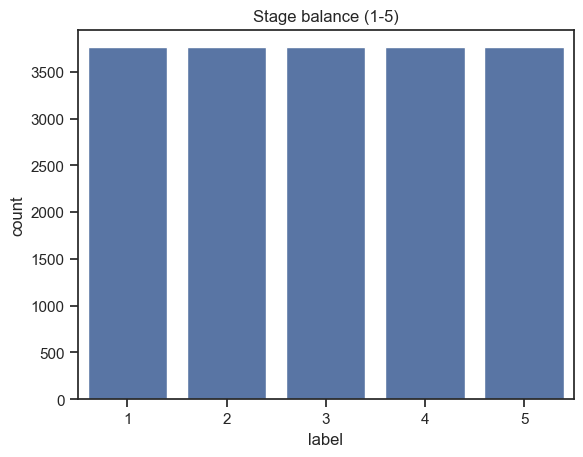

In [4]:
display(X_train.info())
display(X_train.describe().T)
sns.countplot(x=y_train['label']); plt.title('Stage balance (1-5)'); plt.show()

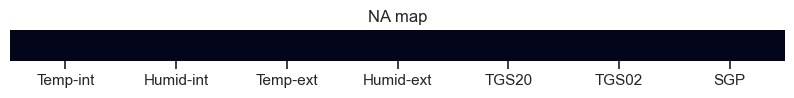

0.00% duplicate rows in X_train


In [5]:
# Missing-value heat-map
plt.figure(figsize=(10,0.4))
sns.heatmap(X_train.isna(), cbar=False); plt.yticks([]); plt.title('NA map'); plt.show()

# Duplicate row check
dup_pct = X_train.duplicated().mean()*100
print(f'{dup_pct:.2f}% duplicate rows in X_train')

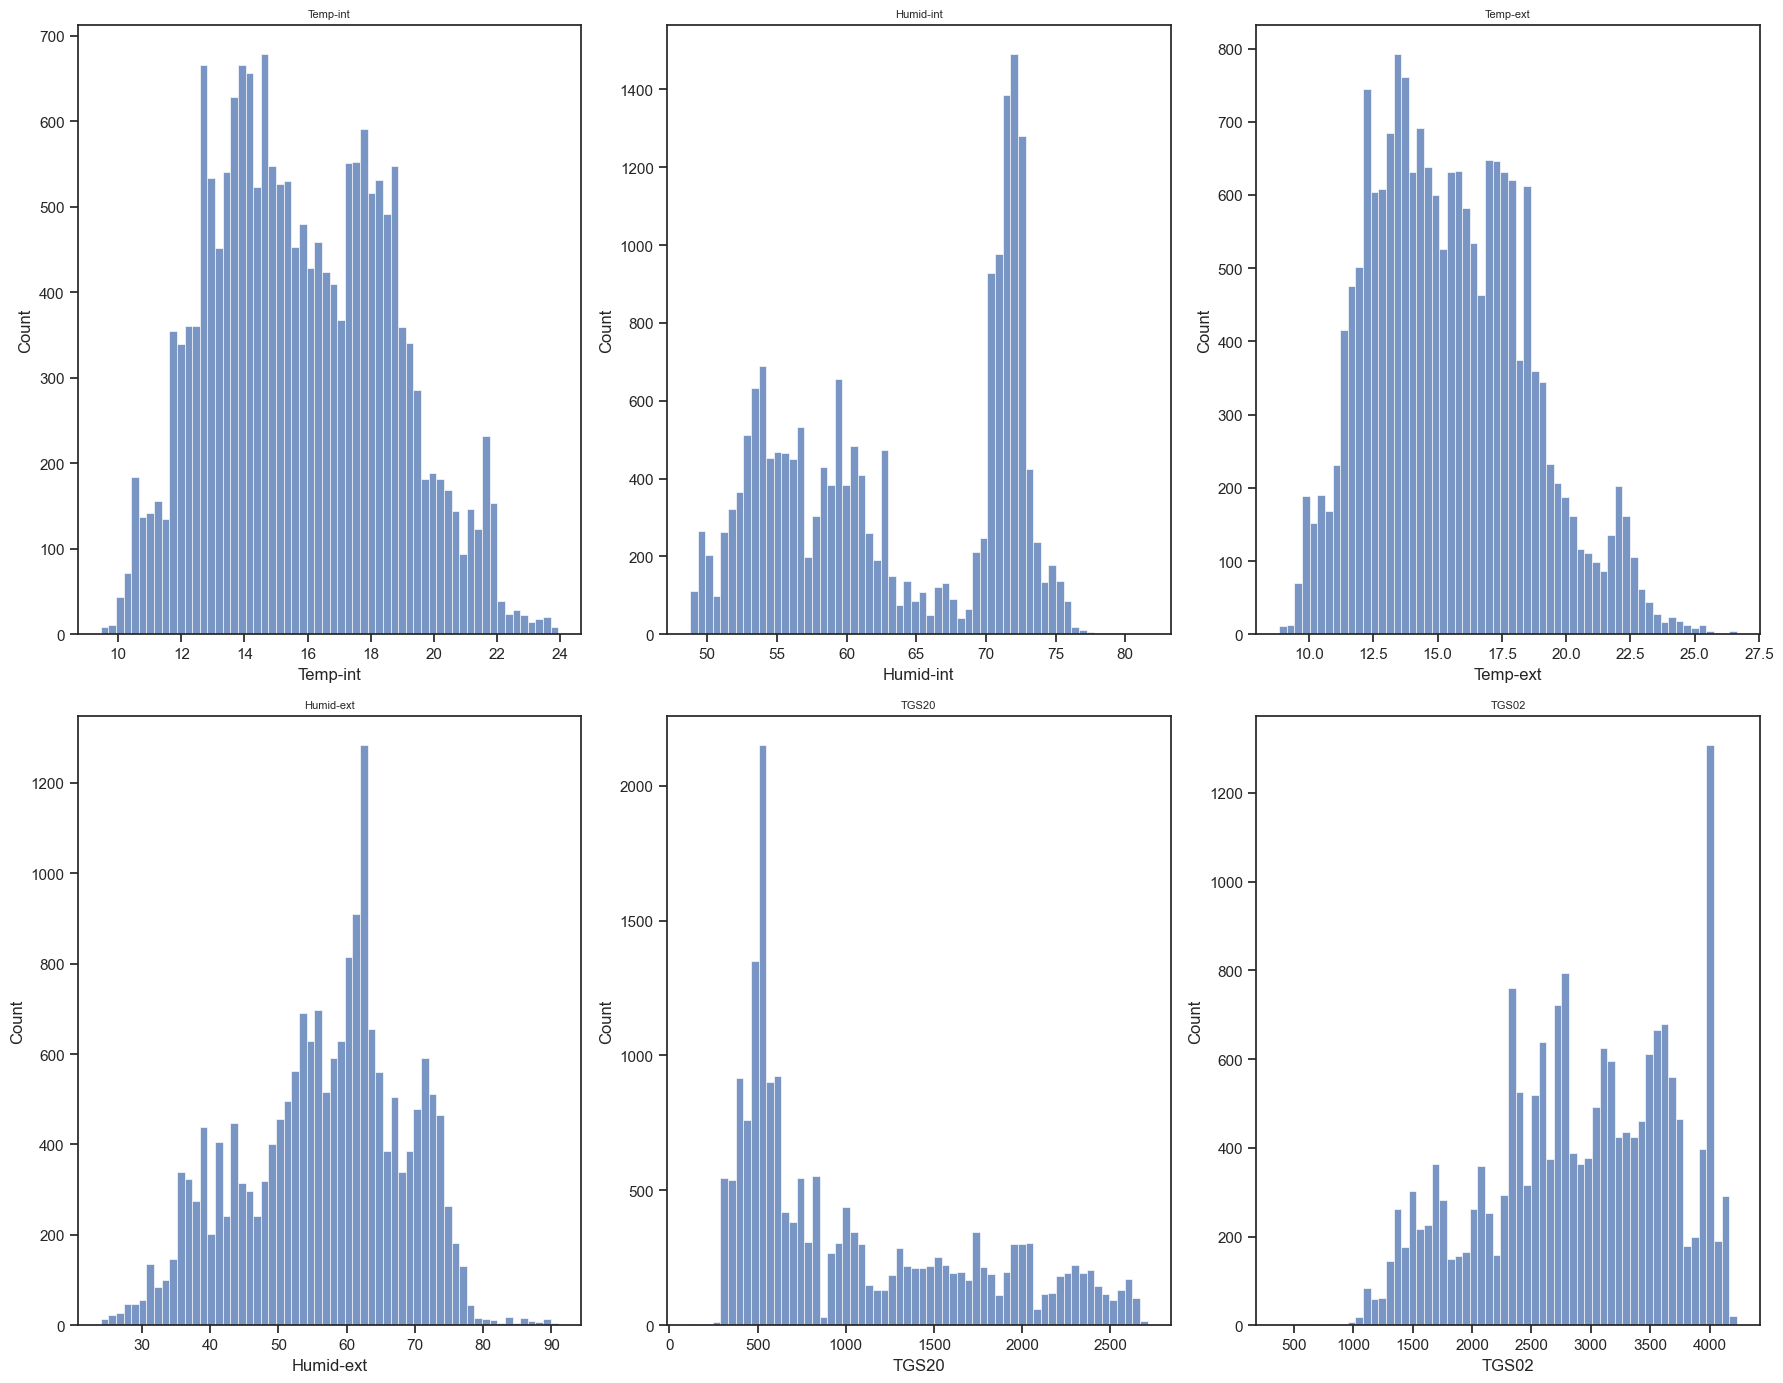

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(18, 14))
for ax, col in zip(axes.flat, X_train.columns):
    sns.histplot(X_train[col], bins=60, ax=ax); ax.set_title(col, fontsize=8)
plt.tight_layout()

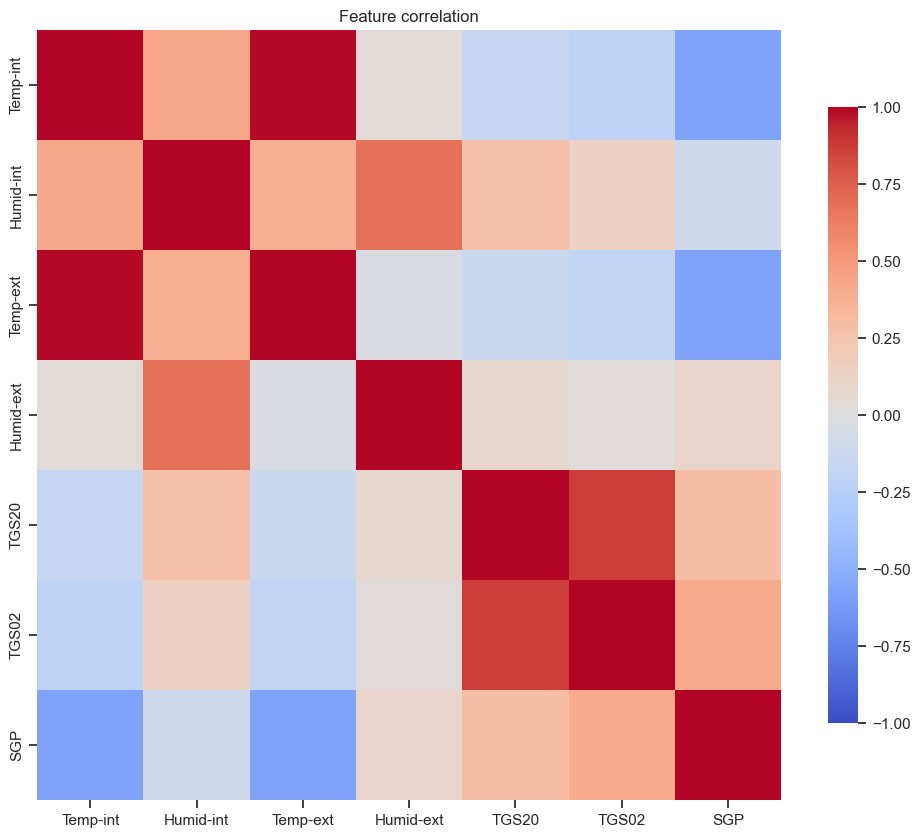

In [7]:
plt.figure(figsize=(12,10))
sns.heatmap(X_train.corr(), cmap='coolwarm', center=0, vmin=-1, vmax=1,
            cbar_kws={'shrink':0.8}); plt.title('Feature correlation'); plt.show()

In [9]:
voc_cols = ['TGS20', 'TGS02', 'SGP']

def engineer(df):
    df = df.copy()

    # log-VOC
    for col in voc_cols:
        df[f'log_{col}'] = np.log1p(df[col])

    # temperature / humidity deltas
    df['dT_delta']  = df['Temp-int']  - df['Temp-ext']
    df['dRH_delta'] = df['Humid-int'] - df['Humid-ext']

    # gas ratio
    df['TGS20_per_SGP'] = df['TGS20'] / (df['SGP'] + 1e-3)

    # 1-hour rolling means (cadence ≈5 min → 12 rows)
    roll_cols = ['Temp-int','Humid-int'] + voc_cols
    for col in roll_cols:
        df[f'{col}_mean1h'] = df[col].rolling(12, min_periods=1).mean()

    return df

X_train = engineer(X_train)
X_test  = engineer(X_test)

In [10]:
def winsorise(df, q=0.995):
    hi = df.quantile(q); lo = df.quantile(1-q)
    return df.clip(lower=lo, upper=hi, axis=1)

X_train = winsorise(X_train); X_test = winsorise(X_test)

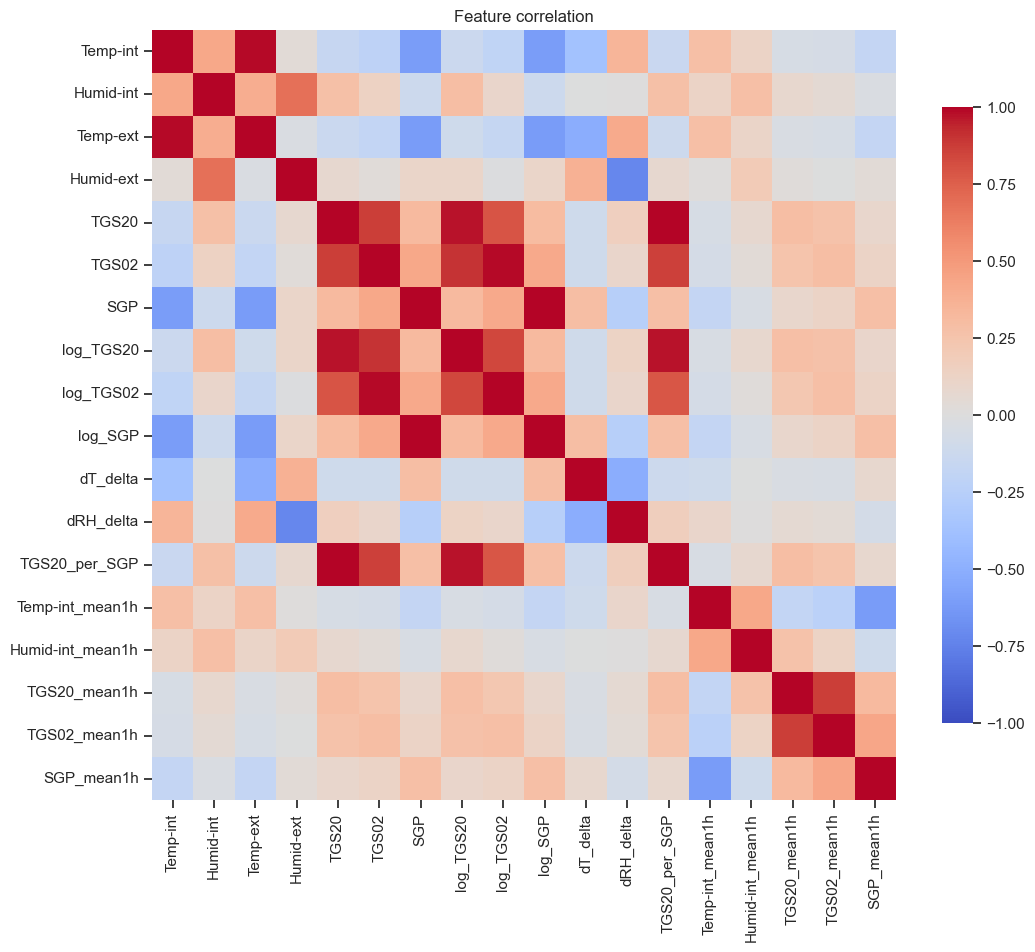

In [11]:
plt.figure(figsize=(12,10))
sns.heatmap(X_train.corr(), cmap='coolwarm', center=0, vmin=-1, vmax=1,
            cbar_kws={'shrink':0.8}); plt.title('Feature correlation'); plt.show()

In [13]:
X_train.to_csv(os.path.join(DATA_DIR, 'X_train_pre.csv'))
y_train.to_csv(os.path.join(DATA_DIR, 'y_train_pre.csv'), header=True)

X_test.to_csv(os.path.join(DATA_DIR, 'X_test_pre.csv'))
y_test.to_csv(os.path.join(DATA_DIR, 'y_test_pre.csv'), header=True)

print('Pre-processed files saved:')
for f in ['X_train_pre.csv','y_train_pre.csv','X_test_pre.csv','y_test_pre.csv']:
    print('   ', f)
print('Final feature count:', X_train.shape[1])

Pre-processed files saved:
    X_train_pre.csv
    y_train_pre.csv
    X_test_pre.csv
    y_test_pre.csv
Final feature count: 18
